In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pandas

In [3]:
!pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
# cloab 字體設定
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2021-12-26 09:14:07--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.142.100, 74.125.142.101, 74.125.142.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vnnujmsje8mni5nnfo7huihbfnqjbk3u/1640510025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-26 09:14:10--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vnnujmsje8mni5nnfo7huihbfnqjbk3u/1640510025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.202.132, 2607:f8b0:400e:c00::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|173.1

In [6]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

In [8]:
#匯入資料
MetaData = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/社群網路分析/縣市合併/rawdata/公投結果_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/社群網路分析/縣市合併/rawdata/公投結果_articleReviews.csv', encoding='UTF-8')

In [9]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,:\n:\n\n為什麼國民黨跟民眾黨常常被女拳扁\n因為根本不懂啥叫女權\n如果女性因為雇主...
1,Re:[新聞]尼加拉瓜斷交凸顯公投重要性林靜儀：決,2021/12/10,16:32:41,https://www.ptt.cc/bbs/HatePolitics/M.16391539...,KINMENKING,HatePolitics,4,1,1,推 joycepinky: 嗯，奇怪這版主老娘沒有黑名單耶XD，反倒是會馬上把上 12/1...
2,[討論]侯友宜算不算是超越藍綠？,2021/12/10,16:34:27,https://www.ptt.cc/bbs/HatePolitics/M.16391540...,chungrew,HatePolitics,33,5,0,從前大家都說\n\n超越藍綠要看柯文哲\n\n但現在看來\n\n侯友宜也可能可以\n\n因為...


In [10]:
Reviews.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,Cishang,→,2021-12-11 00:15:47,:現在開始打這個真的是窮途末路了
1,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,KingFelix,→,2021-12-11 00:15:47,:這個好啊！不然去那邊要幹嘛看這個舒服多了
2,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,aaaba,推,2021-12-11 00:15:47,:看八卦板同篇推文柯韓粉超得意，以為打中民進黨要害了


In [11]:
# 合併每篇文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent", "cmtPoster", "cmtStatus", "cmtContent"]], how = "left", on = 'artUrl')

In [12]:
print(Reviews.shape)
Reviews.head(3)

(94218, 13)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,cmtPoster,cmtStatus,cmtContent
0,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,:現在開始打這個真的是窮途末路了,Cishang,→,:現在開始打這個真的是窮途末路了
1,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,:這個好啊！不然去那邊要幹嘛看這個舒服多了,KingFelix,→,:這個好啊！不然去那邊要幹嘛看這個舒服多了
2,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,:看八卦板同篇推文柯韓粉超得意，以為打中民進黨要害了,aaaba,推,:看八卦板同篇推文柯韓粉超得意，以為打中民進黨要害了


In [13]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('\n', ',', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

In [14]:
#整理Reviews格式
# Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub(':', '', str(x)))
# Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('\n', ',', x))
# Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

In [15]:
#設定繁體中文詞庫
jieba.set_dictionary('/content/drive/MyDrive/Colab Notebooks/社群網路分析/縣市合併/dict/dict.txt.big')

#新增疫情相關自定義字典
jieba.load_userdict('/content/drive/MyDrive/Colab Notebooks/社群網路分析/縣市合併/dict/user_dict.txt')

#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('/content/drive/MyDrive/Colab Notebooks/社群網路分析/縣市合併/dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /content/drive/MyDrive/Colab Notebooks/社群網路分析/縣市合併/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u9ae122164e069af3423c6dfbb4bca3dc.cache
Loading model cost 2.625 seconds.
Prefix dict has been built successfully.


In [16]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [17]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

In [18]:
data.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,":,:,,為什麼國民黨跟民眾黨常常被女拳扁,因為根本不懂啥叫女權,如果女性因為雇主要求被強迫...","[國民黨, 跟民眾, 女拳, 女權, 女性, 雇主, 強迫, 清涼, ---, 違反, 女權..."
1,Re:[新聞]尼加拉瓜斷交凸顯公投重要性林靜儀：決,2021/12/10,16:32:41,https://www.ptt.cc/bbs/HatePolitics/M.16391539...,KINMENKING,HatePolitics,4,1,1,"推 ,: 嗯，奇怪這版主老娘沒有黑名單耶,，反倒是會馬上把上 ,/, ,:,,→ ,: 面...","[奇怪, 版主, 老娘, 黑名單, 留言, 黑冥單, 哈哈哈, 幫補, 會噓, 還用, 黑名..."
2,[討論]侯友宜算不算是超越藍綠？,2021/12/10,16:34:27,https://www.ptt.cc/bbs/HatePolitics/M.16391540...,chungrew,HatePolitics,33,5,0,"從前大家都說,,超越藍綠要看柯文哲,,但現在看來,,侯友宜也可能可以,,因為侯友宜主張,,『...","[從前, 超越, 藍綠, 柯文, 侯友宜, 侯友宜, 事前, 表態, 公投, 民意, 依歸,..."


In [19]:
token_data = data['word'].tolist()

In [20]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(33238 unique tokens: ['---', '中抖', '列舉', '只能', '問說']...)


In [21]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 3), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 5), (7, 3), (8, 9), (9, 1)]


In [22]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus,  # 文檔語料庫
    id2word=id2word, # 詞彙字典
    num_topics=3, # 生成幾個主題數
    random_state=1205, # 亂數
    iterations = 1000, # 每個文章訓練的次數，可以設定高一點讓模型收斂
    passes=5, # 模型訓練次數
)

In [23]:
#ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
#pyLDAvis.save_html(ldaVis,'ldaVis.html')

In [24]:
# 每個主題重要的前25個關鍵字
topics = ldamodel.print_topics(num_words=25)
for topic in topics:
    print(topic)
    print("")

(0, '0.010*"台灣" + 0.008*"民進黨" + 0.006*"國民黨" + 0.005*"公投" + 0.004*"總統" + 0.003*"中國" + 0.003*"美國" + 0.003*"政治" + 0.003*"市長" + 0.003*"民主" + 0.002*"韓國" + 0.002*"真的" + 0.002*"政府" + 0.002*"新聞" + 0.002*"柯文" + 0.002*"立委" + 0.002*"萊豬" + 0.002*"英文" + 0.002*"轉錄" + 0.002*"選舉" + 0.002*"日本" + 0.002*"執政" + 0.002*"支持" + 0.002*"金門" + 0.002*"內容"')

(1, '0.032*"公投" + 0.016*"國民黨" + 0.014*"民進黨" + 0.011*"同意" + 0.009*"不同意" + 0.008*"投票" + 0.008*"核四" + 0.007*"台灣" + 0.007*"萊豬" + 0.005*"侯友宜" + 0.004*"大選" + 0.004*"四個" + 0.004*"支持" + 0.004*"選舉" + 0.004*"市長" + 0.004*"議題" + 0.004*"真的" + 0.004*"柯文" + 0.003*"新聞" + 0.003*"選民" + 0.003*"民眾" + 0.003*"政府" + 0.003*"投票率" + 0.003*"四大" + 0.003*"政黨"')

(2, '0.013*"台灣" + 0.010*"公投" + 0.008*"萊豬" + 0.006*"美國" + 0.005*"核四" + 0.005*"日本" + 0.004*"國民黨" + 0.004*"政府" + 0.003*"進口" + 0.003*"開放" + 0.003*"真的" + 0.003*"中國" + 0.003*"民進黨" + 0.002*"國家" + 0.002*"經濟" + 0.002*"總統" + 0.002*"議題" + 0.002*"食品" + 0.002*"豬肉" + 0.002*"支持" + 0.002*"政治" + 0.002*"福島" + 0.002*"地方" + 0.002*"核食" + 0.002*"藍營"')

topic0:各國政府對於台灣公投等相關政治報導  
topic1:政黨對於公投案的各自主張  
topic2:政黨針對部分公投案的相關報導(萊豬、核四)

*以下我們挑出 第一個主題 與 第二個主題 來做比較。

以每筆發文的"主題分佈"中分數最大的主題當作該文章的主題


###使用"c_v"之coherence方式得出PMI score

In [25]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence= 'c_v')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  0.43367504904868454


### 複雜度數值越小越好

In [26]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -8.810392230757559


### 以每筆發文的"主題分佈"中分數最大的主題當作該文章的主題

In [27]:
# 取得每筆發文的主題分佈
topics_doc = ldamodel.get_document_topics(corpus,minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [ [entry[1] for entry in doc] for doc in topics_doc ]
print(probabilities[0:3])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]

[[0.9869312, 0.006680741, 0.0063880705], [0.394689, 0.597437, 0.00787394], [0.0047659376, 0.99073225, 0.0045018326]]


In [28]:
# 將結果放進 DataFrame裏
data['topic'] = doc_list

In [29]:
data[["artTitle","topic"]].head(5)

,artTitle,topic
0,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,0
1,Re:[新聞]尼加拉瓜斷交凸顯公投重要性林靜儀：決,1
2,[討論]侯友宜算不算是超越藍綠？,1
3,[討論]現在民進黨484開始抄襲國民黨啊,1
4,[黑特]侯友宜盧秀燕林姿妙全跳船,1


In [92]:
data[(data["topic"]==1)&(data["artTitle"].str.contains("同意"))][["artTitle","topic"]].sample(n=5)


,artTitle,topic
827,[新聞]侯友宜成戰犯？藍營公投民調新北同意票率,1
657,Re:[討論]核四重啟，同意率最高縣市放核廢料好嗎？,1
2302,[討論]幹，這幾天我投下的三件不同意….,1
1163,Re:[討論]三個同意一個不同意,1
1560,[討論]公投我輸了。我沒有投四個不同意。,1


In [93]:
data[(data["topic"]==2)&(data["artTitle"].str.contains("萊豬"))][["artTitle","topic"]].sample(n=5)


,artTitle,topic
1942,[新聞]反萊豬公投未通過學者：政府可盡快回歸C,2
812,[討論]再談萊豬議題VS國際經貿,2
166,Re:[討論]為什麼不進口萊豬台美關係就會倒退？,2
609,Re:[討論]萊豬應該是輸了,2
2517,Re:[討論]萊豬之後是核食，我OK阿,2


In [33]:
# 轉換artDate為 Python 日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y-%m-%d")

In [34]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':data.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
date_topic

,artDate,topic,count
0,2021-12-10,0,2
1,2021-12-10,1,9
2,2021-12-10,2,1
3,2021-12-11,0,12
4,2021-12-11,1,58
5,2021-12-11,2,43
6,2021-12-12,0,25
7,2021-12-12,1,105
8,2021-12-12,2,35
9,2021-12-13,0,15


In [35]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2']
date_df = date_df.set_index('artDate')
date_df



,topic0,topic1,topic2
artDate,,,
2021-12-10,2,9,1
2021-12-11,12,58,43
2021-12-12,25,105,35
2021-12-13,15,117,26
2021-12-14,21,121,46
2021-12-15,20,128,38
2021-12-16,11,122,43
2021-12-17,16,190,65
2021-12-18,23,590,63


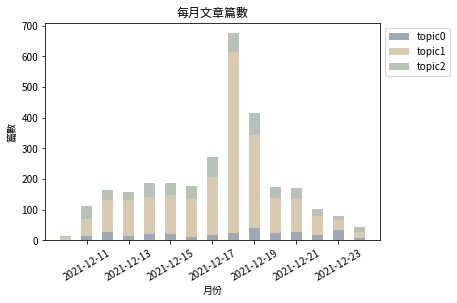

In [37]:
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8", "#EAD0D5"]
column = ['topic0', 'topic1', 'topic2']
temp_bottom = 0

for i in range(0,3):
    if(i>0):
        temp_bottom = temp_bottom + date_df[column[i-1]]
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], label=column[i] , width=0.5)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

公投前後民眾對於公投議題討論熱烈

In [38]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2 

for i in range(0,3):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

,topic0,topic1,topic2,sum
artDate,,,,
2021-12-10,0.166667,0.750000,0.083333,12
2021-12-11,0.106195,0.513274,0.380531,113
2021-12-12,0.151515,0.636364,0.212121,165
2021-12-13,0.094937,0.740506,0.164557,158
2021-12-14,0.111702,0.643617,0.244681,188
2021-12-15,0.107527,0.688172,0.204301,186
2021-12-16,0.062500,0.693182,0.244318,176
2021-12-17,0.059041,0.701107,0.239852,271
2021-12-18,0.034024,0.872781,0.093195,676


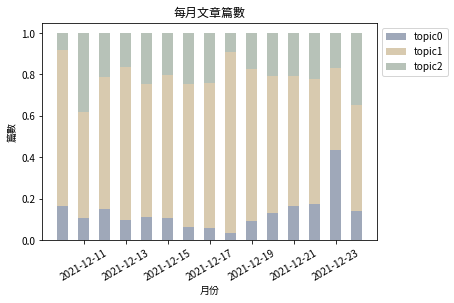

In [39]:
temp_bottom = 0

for i in range(0,3):
    if(i>0):
        temp_bottom = temp_bottom + ratio_df[column[i-1]]
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i], width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], label=column[i], width=0.5)

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()


Topic1一直都維持著高度比例，可見此次公投民眾對於政黨提出的同意或不同意口號討論熱烈

In [40]:
## 主題一
data[data['topic'] == 1].sample(n=5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word,topic
1321,[討論]四個公投都不過？,2021-12-18,05:03:55,https://www.ptt.cc/bbs/HatePolitics/M.16398038...,twoquarters,HatePolitics,50,21,4,"如題，公投有可能會通通都不過,,但不是民進黨有多神通廣大,而是,北部天氣冷,加上,王,宏,崩...","[公投, 通通, 民進黨, 神通廣大, 北部, 天氣, 崩壞, 新聞, 鋪天蓋地, 襲來, ...",1
1208,[討論]關於美萊豬的投法，你同意或不同意？,2021-12-17,14:00:24,https://www.ptt.cc/bbs/HatePolitics/M.16397496...,ysb727,HatePolitics,4,0,0,"這條吼,,關係到你我以後吃東西,,請問政黑的大大們,,這條,,你們會投同意還是不同意呢？,,...","[這條, 關係, 東西, 請問, 政黑, 這條, 同意, 不同意, 不想, 萊豬, 總覺, ...",1
1982,[討論]公投結果顯示塔綠畜基本盤慘敗於藍營,2021-12-19,01:32:06,https://www.ptt.cc/bbs/HatePolitics/M.16398775...,macaron5566,HatePolitics,30,10,11,"塔綠畜,輸定了。,,這次公投結果，看似藍營輸了幾十萬票，,,但只要檢視兩陣營的動員程度就知道...","[塔綠畜, 輸定, 公投, 看似, 藍營輸, 幾十萬, 檢視, 陣營, 動員, 程度, 塔綠...",1
21,[新聞]公投大遊行侯友宜、林姿妙不參加黃敏惠,2021-12-11,02:14:09,https://www.ptt.cc/bbs/HatePolitics/M.16391888...,akway,HatePolitics,8,5,0,"公投大遊行 侯友宜、林姿妙不參加 黃敏惠將現身破謠言,,自由,,〔記者施曉光／台北報導〕雖然...","[公投, 遊行, 侯友宜, 林姿妙, 參加, 敏惠, 現身, 謠言, 自由, 施曉光, 台北...",1
2049,Re:[討論]從這次公投看台灣民主素養,2021-12-19,03:35:23,https://www.ptt.cc/bbs/HatePolitics/M.16398849...,takuminauki,HatePolitics,5,3,0,"投四個同意民主素養低我知道,投四個不同意沒有民主素養?,你想挑戰我這個投四個不同意的人嗎?,...","[四個, 同意, 民主, 素養, 四個, 不同意, 民主, 素養, 挑戰, 四個, 不同意,...",1


In [41]:
data[data['topic'] == 2].sample(n=5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word,topic
2259,[討論]藍營公投潰敗的破口，就是黃士修,2021-12-19,12:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16399154...,orinsinal,HatePolitics,60,25,3,"四大公投案藍營潰敗與風向逆轉之始，個人覺得就是黃士修對上台電核發處長這場,,蔡英文這張圖，簡...","[四大, 投案, 藍營, 潰敗, 風向, 逆轉, 之始, 黃士, 修對, 上台, 核發, 處...",2
121,[討論]能不能給我一個反萊豬的理由？,2021-12-11,17:59:00,https://www.ptt.cc/bbs/HatePolitics/M.16392455...,Yyh,HatePolitics,47,14,6,"公投主文：你是否同意政府應全面禁止進口含有瘦肉精（萊克多巴胺等乙型受體素）豬隻,之肉品、內臟...","[公投, 主文, 同意, 政府, 全面禁止, 進口, 含有, 瘦肉精, 萊克, 多巴胺, 乙...",2
2022,[討論]民進黨還是要交代萊豬哪裡可以買到阿,2021-12-19,02:43:07,https://www.ptt.cc/bbs/HatePolitics/M.16398817...,nicholas0406,HatePolitics,61,23,1,"我尊重公投結果,,但你民進黨政府開放萊豬進口,,你至少也要交代清楚說 哪裡可以買到萊豬來吃啊...","[尊重, 公投, 民進黨, 政府, 開放, 萊豬, 進口, 至少, 交代, 萊豬, 去逛, ...",2
1501,[黑特]國民黨反萊豬就是腦殘,2021-12-18,09:37:32,https://www.ptt.cc/bbs/HatePolitics/M.16398202...,jackie0414,HatePolitics,10,3,1,"每次這個板只要問一句,,萊牛可以吃，為什麼萊豬不能吃？,,沒有一個四趴柯韓粉可以說出來什麼鬼...","[每次, 一句, 萊牛, 萊豬, 趴柯, 韓粉, 東西, 公投, 辯論, 國民黨, 腦子, ...",2
2334,[黑特]公投禁止荷包蛋加鹽!,2021-12-19,17:01:52,https://www.ptt.cc/bbs/HatePolitics/M.16399333...,adagiox,HatePolitics,16,3,9,"台灣有一派很可惡的人，就是荷包蛋竟然加鹽吃!,荷包蛋應該加醬油哪有人在加鹽?,,公投荷包蛋禁...","[台灣, 一派, 可惡, 荷包蛋, 加鹽, 荷包蛋, 醬油, 有人, 加鹽, 公投, 荷包蛋...",2


#社群網絡分析
社群網絡分析就是運用圖論(Graph theory)從這些節點和連結去研究人與人之間的關係以及整個群體的結構。

In [43]:
data.head(1)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word,topic
0,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021-12-10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,":,:,,為什麼國民黨跟民眾黨常常被女拳扁,因為根本不懂啥叫女權,如果女性因為雇主要求被強迫...","[國民黨, 跟民眾, 女拳, 女權, 女性, 雇主, 強迫, 清涼, ---, 違反, 女權...",0


In [44]:
Reviews.head(5)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,cmtPoster,cmtStatus,cmtContent
0,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,:現在開始打這個真的是窮途末路了,Cishang,→,:現在開始打這個真的是窮途末路了
1,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,:這個好啊！不然去那邊要幹嘛看這個舒服多了,KingFelix,→,:這個好啊！不然去那邊要幹嘛看這個舒服多了
2,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,:看八卦板同篇推文柯韓粉超得意，以為打中民進黨要害了,aaaba,推,:看八卦板同篇推文柯韓粉超得意，以為打中民進黨要害了
3,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,:這個不行，眼光可以再高一點好嗎？,Sinful,→,:這個不行，眼光可以再高一點好嗎？
4,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021/12/10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,:女權是她們要穿多露都可以，她們自己的事自己負責吧，怎,MVPGGYY,推,:女權是她們要穿多露都可以，她們自己的事自己負責吧，怎


In [45]:
# 把reviews中 cmtPoster(回覆者), cmtStatus(推噓), cmtContent(留言) 合併到 data的資料表
posts_Reviews = Reviews.loc[:,["artUrl", "cmtPoster", "cmtStatus", "cmtContent"]]
posts_Reviews  = pd.merge(data, posts_Reviews, how="right", on="artUrl")
posts_Reviews = posts_Reviews[posts_Reviews["commentNum"]>0]

In [46]:
posts_Reviews.head(2)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word,topic,cmtPoster,cmtStatus,cmtContent,cmtContent
0,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021-12-10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,":,:,,為什麼國民黨跟民眾黨常常被女拳扁,因為根本不懂啥叫女權,如果女性因為雇主要求被強迫...","[國民黨, 跟民眾, 女拳, 女權, 女性, 雇主, 強迫, 清涼, ---, 違反, 女權...",0,Cishang,→,:現在開始打這個真的是窮途末路了,:現在開始打這個真的是窮途末路了
1,Re:[新聞]民進黨公投宣講搬出「辣妹熱舞」！他看傻怒喊：,2021-12-10,16:15:47,https://www.ptt.cc/bbs/HatePolitics/M.16391529...,judoyang,HatePolitics,35,12,0,":,:,,為什麼國民黨跟民眾黨常常被女拳扁,因為根本不懂啥叫女權,如果女性因為雇主要求被強迫...","[國民黨, 跟民眾, 女拳, 女權, 女性, 雇主, 強迫, 清涼, ---, 違反, 女權...",0,KingFelix,→,:這個好啊！不然去那邊要幹嘛看這個舒服多了,:這個好啊！不然去那邊要幹嘛看這個舒服多了


In [47]:
# 取出 cmtPoster(回覆者)、artPoster(發文者)、artUrl(文章連結) 三個欄位
link = posts_Reviews.loc[:,["cmtPoster", "artPoster", "artUrl"]]
link.head(5)

,cmtPoster,artPoster,artUrl
0,Cishang,judoyang,https://www.ptt.cc/bbs/HatePolitics/M.16391529...
1,KingFelix,judoyang,https://www.ptt.cc/bbs/HatePolitics/M.16391529...
2,aaaba,judoyang,https://www.ptt.cc/bbs/HatePolitics/M.16391529...
3,Sinful,judoyang,https://www.ptt.cc/bbs/HatePolitics/M.16391529...
4,MVPGGYY,judoyang,https://www.ptt.cc/bbs/HatePolitics/M.16391529...


In [48]:
len(link)


94168

使用 cmtPoster(回覆者)、artPoster(發文者) 建立兩者的連結

In [49]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,100):
    G.add_edge(link["cmtPoster"][i], link["artPoster"][i])
    

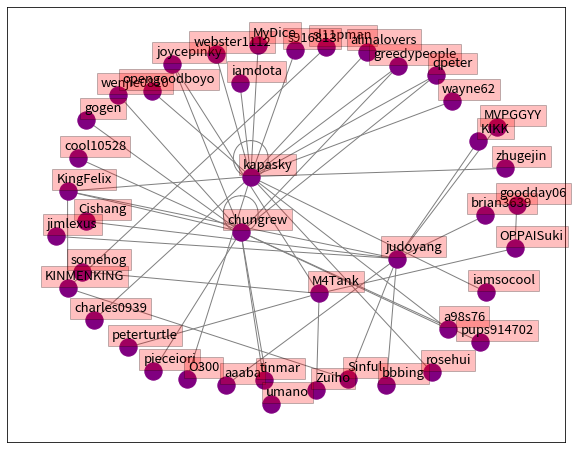

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

Text(0, 0.5, 'count')

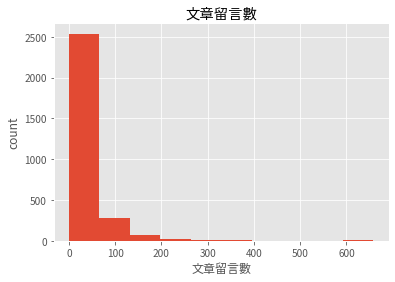

In [51]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.hist(data["commentNum"])

plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

In [52]:
# 帳號發文篇數
pd.DataFrame(data.groupby("artPoster").size(),columns = ['count']).reset_index().sort_values(by="count",ascending=False)

,artPoster,count
384,ismail,41
525,nicholas0406,35
313,eunhailoveu,33
669,takuminauki,33
39,GV13,30
...,...,...
420,keroro39,1
418,kapasky,1
124,SuperKMT,1
416,julianscorpi,1


In [53]:
# 檢視人數
print("發文者數量總共:",len(set(posts_Reviews["artPoster"])))
print("回覆者數量總共:",len(set(posts_Reviews["cmtPoster"])))

發文者數量總共: 766
回覆者數量總共: 5336


In [54]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["artPoster"])+list(posts_Reviews["cmtPoster"]))

In [55]:
allPoster = pd.DataFrame(list(s),columns=["user"])

In [56]:
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(data["artPoster"]) else "replayer")


In [57]:
allPoster.head(5)


,user,type
0,peatle,replayer
1,pocariccw,replayer
2,s880303,replayer
3,lunarblue,replayer
4,jackfan1015,replayer


公投當天12/18討論火熱，因此選擇這天

In [58]:

posts_Reviews_0522 = (posts_Reviews.query('artDate == "2021-12-18"')
                      .query('commentNum>100')
                      .groupby(['cmtPoster','artUrl'],as_index=False).size()
                     )

In [59]:
# 篩選有人在同一篇文章重複回覆大於5次
posts_Reviews_0522 = posts_Reviews_0522.query('size>3')
posts_Reviews_0522.head(3)


,cmtPoster,artUrl,size
28,AllenHuang,https://www.ptt.cc/bbs/HatePolitics/M.16398326...,6
76,BraveCattle,https://www.ptt.cc/bbs/HatePolitics/M.16398130...,7
90,CTHsieh,https://www.ptt.cc/bbs/HatePolitics/M.16398431...,5


In [60]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0522 = pd.merge(posts_Reviews_0522,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0522.reset_index(inplace=True, drop=True) #重設index
link_0522.head(3)

,cmtPoster,artUrl,size,artPoster
0,AllenHuang,https://www.ptt.cc/bbs/HatePolitics/M.16398326...,6,genheit
1,BraveCattle,https://www.ptt.cc/bbs/HatePolitics/M.16398130...,7,ismail
2,CTHsieh,https://www.ptt.cc/bbs/HatePolitics/M.16398431...,5,semih


In [61]:
# Create network plot 
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,len(link_0522)):
    G.add_edge(link_0522["cmtPoster"][i], link_0522["artPoster"][i])

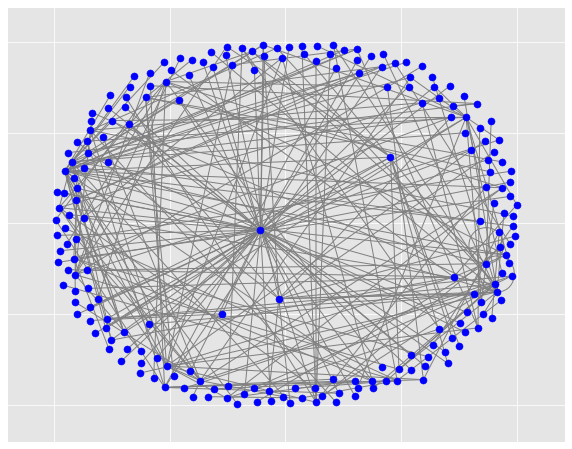

In [62]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color="blue",
                 with_labels = False,
                 ax=ax)
    
plt.show()

加上nodes的顯示資訊
用使用者的身份來區分點的顏色

poster:red(有發文)
replyer:blue(只有回覆文章)

In [63]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

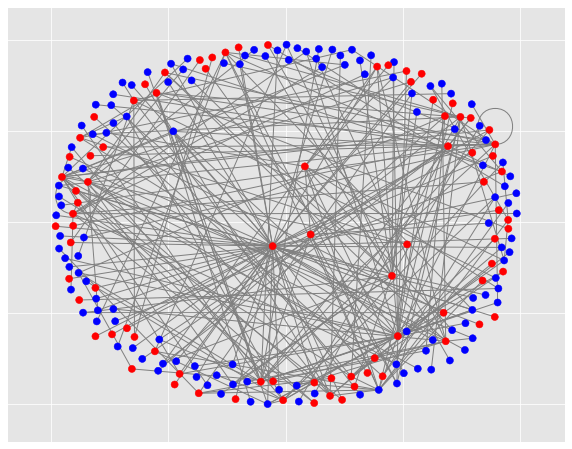

In [64]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)
    
plt.show()

為點加上帳號名字，用degree篩選要顯示出的使用者(degree>5)，以免圖形被密密麻麻的文字覆蓋。

In [65]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [66]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [67]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees

['ismail',
 'semih',
 'rayisgreat',
 'algebraic',
 'takizawa5566',
 'midas82539',
 'twnndnpdnc',
 'Friend5566',
 'hbk20491',
 'hawk920412',
 'dog990999',
 'umano']

In [68]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


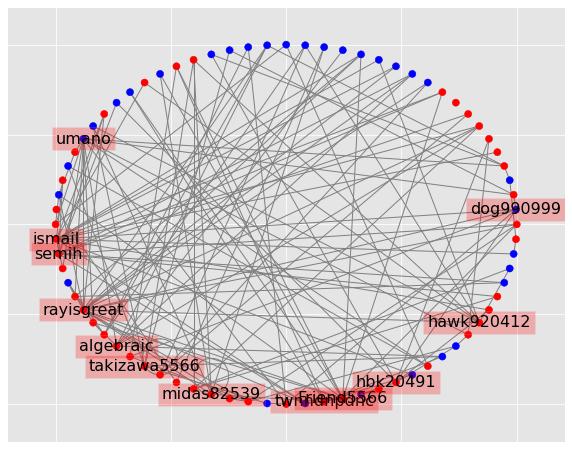

In [69]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
# pos = nx.spring_layout(G, k=2)
pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

計算Centrality
找出重要的點

In [70]:
# degree centrality
degree = nx.degree_centrality(G)
degree

{'Crazyfire': 0.05333333333333334,
 'Friend5566': 0.13333333333333333,
 'O300': 0.02666666666666667,
 'OoJudyoO': 0.02666666666666667,
 'Pietro': 0.05333333333333334,
 'Robben': 0.06666666666666667,
 'Sentimental': 0.02666666666666667,
 'ShockG': 0.02666666666666667,
 'WTF55665566': 0.04,
 'WeGoYuSheng': 0.04,
 'WiserWilly': 0.05333333333333334,
 'a10141013': 0.06666666666666667,
 'aaaba': 0.05333333333333334,
 'akway': 0.06666666666666667,
 'algebraic': 0.09333333333333334,
 'alinalovers': 0.02666666666666667,
 'bezbol': 0.06666666666666667,
 'ccl007': 0.02666666666666667,
 'cheinshin': 0.04,
 'clifflee': 0.02666666666666667,
 'ct412133': 0.02666666666666667,
 'demonh311': 0.02666666666666667,
 'dlija7814': 0.05333333333333334,
 'dog990999': 0.08,
 'dream4118': 0.02666666666666667,
 'eunhailoveu': 0.02666666666666667,
 'foolfighter': 0.02666666666666667,
 'fragmentwing': 0.05333333333333334,
 'freeclouds': 0.02666666666666667,
 'genheit': 0.04,
 'gogoto990': 0.04,
 'greedypeople': 0.0

In [71]:
# eigenvector centrality
eigenvector = nx.eigenvector_centrality(G)

In [72]:
# pagerank centrality
pr = nx.pagerank(G, alpha=0.9)

In [73]:
# betweenness centrality
between = nx.betweenness_centrality(G)

In [94]:
# 找出degree centrality最高的前5名
print("degree centrality:",sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
print("eigenvector centrality:",sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:",sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:",sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['rayisgreat', 'ismail', 'umano', 'semih', 'Friend5566']
eigenvector centrality: ['rayisgreat', 'Friend5566', 'ismail', 'umano', 'Robben']
pagerank centrality: ['rayisgreat', 'ismail', 'umano', 'semih', 'Friend5566']
betweenness centrality: ['rayisgreat', 'umano', 'ismail', 'dog990999', 'midas82539']


可看出大致上各方法所判斷節點重要性差所判斷節點重要性差異不大，除了betweenness方法

挑選出2021-12-18當天的文章， 篩選一篇文章回覆5次以上者，且文章留言數大於100則， 文章主題歸類為1(政黨公投相關立場)與2(特定公投議題) 欄位只取：cmtPoster(評論者), artPoster(發文者), artUrl(文章連結), topic(主題)

In [75]:
# 加上topic
topic_0522 = pd.merge(link_0522,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic"]].drop_duplicates()

In [76]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0522_topic = pd.merge(topic_0522,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0522_topic.reset_index(inplace=True, drop=True) #重設index
link_0522_topic.head(3)

,cmtPoster,artUrl,topic,artPoster
0,AllenHuang,https://www.ptt.cc/bbs/HatePolitics/M.16398326...,2,genheit
1,BraveCattle,https://www.ptt.cc/bbs/HatePolitics/M.16398130...,1,ismail
2,CTHsieh,https://www.ptt.cc/bbs/HatePolitics/M.16398431...,1,semih


In [95]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge = [] 
for i in range(0,len(link_0522_topic)):
    G.add_edge(link_0522_topic["cmtPoster"][i], link_0522_topic["artPoster"][i])
    if link_0522_topic["topic"][i] == 0: #以主題區分顏色
        color_map_edge.append('orange')
    elif link_0522_topic["topic"][i] == 1:
        color_map_edge.append('green')
    else: 
        color_map_edge.append('grey') # 主題二:調侃相關 

In [96]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [97]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [98]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

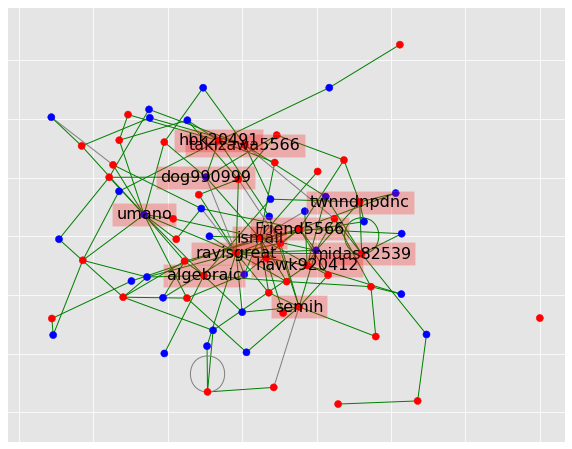

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G,k=0.3)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

從圖中可看出，用戶semih較多topic1相關討論留言

In [82]:
# 加上status
status_0522 = pd.merge(link_0522,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic","cmtStatus"]].drop_duplicates()
# 去掉"→"的資料
status_0522 = status_0522[status_0522["cmtStatus"]!="→"]

In [83]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0522_status = pd.merge(status_0522,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0522_status.reset_index(inplace=True, drop=True) #重設index
link_0522_status.head(3)

,cmtPoster,artUrl,topic,cmtStatus,artPoster
0,AllenHuang,https://www.ptt.cc/bbs/HatePolitics/M.16398326...,2,推,genheit
1,BraveCattle,https://www.ptt.cc/bbs/HatePolitics/M.16398130...,1,推,ismail
2,CTHsieh,https://www.ptt.cc/bbs/HatePolitics/M.16398431...,1,推,semih


In [84]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge_S = []
for i in range(0,len(link_0522_status)):
    G.add_edge(link_0522_status["cmtPoster"][i], link_0522_status["artPoster"][i])
    if link_0522_status["cmtStatus"][i] == "推":
        color_map_edge_S.append('orange')
    else: 
        color_map_edge_S.append('grey')    

In [85]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [86]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red')

In [87]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>2]

# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


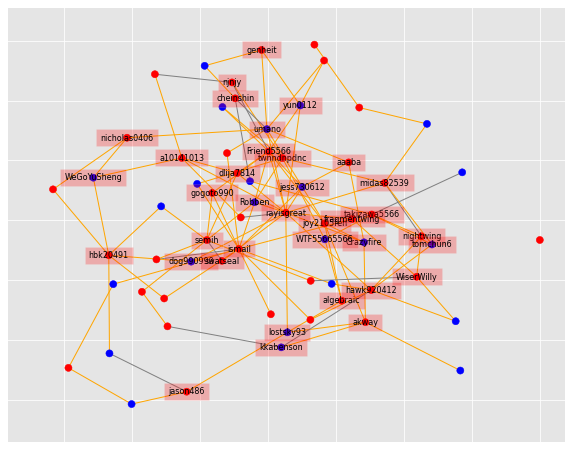

In [88]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.4)
# pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge_S,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=8,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()


可以發現本次的討論中幾乎都是推文、噓文非常之少